# Robot

## Tasks and Resource Ownership

### Tasks

1) main (asyncio)
2) controller (timer interrupt)

### Resource Ownership

* `uart`: main
* `nstby`: main
* `_encX`: controller
* `_motors`: main for now, later controller
* `_duty`: main for now, later controller

In [6]:
%register 'serial:///dev/serial0'
%connect robot-stm
%rsync
%softreset

import robot

%%host

import nest_asyncio
nest_asyncio.apply()

from iot_device.pydevice import Pydevice
from serial import Serial
from array import array
from struct import unpack
import numpy as np
import asyncio, time

def const(x): return bytes([x])

_CMD_DUTY     = const(11)
_CMD_START    = const(12)
_CMD_STOP     = const(13)
_CMD_SHUTDOWN = const(14)
_CMD_PING     = const(15)
_CMD_REPORT_STATE = const(16)

_CMD_MSG      = const(64)
_CMD_ISTATE   = const(65)

def const(x): return x

_STATE_K      = const(0)
_STATE_DT     = const(1)
_STATE_ENC1   = const(2)
_STATE_ENC2   = const(3)
_STATE_DUTY1  = const(4)
_STATE_DUTY2  = const(5)


class BuildArray:
    """Build np array iteratively."""
    
    def __init__(self, cols, max_rows=10000):
        """Number of column & max number of rows"""
        self.rows = 0
        self.cols = cols
        self.array = np.zeros((max_rows, cols))
        
    def add_row(self, v):
        """v is a vector of length cols"""
        self.array[self.rows] = v
        self.rows += 1
        
    def resize(self):
        """Resize to actual size. Now add_row can't be called anymore."""
        self.array.resize((self.rows, self.cols))
        return self.array


def repl_no_follow(cmd):
    with Serial('/dev/serial0', 115200, timeout=0.5, write_timeout=2, exclusive= True) as serial:
        pyb = Pydevice(serial)
        pyb.enter_raw_repl()
        pyb.exec_raw_no_follow(cmd)
        
        
class Robot:
    
    def __init__(self):
        self.baudrate = 1000000
        self.fs       = 100
        self.pwm_freq = 10000
        self.i_state  = BuildArray(cols=8, max_rows=1000)
        
    async def cmd_handler(self):
        serial = self.serial
        while True:
            if serial.in_waiting:
                t = serial.read(1)
                # print("type", t)
                if t == _CMD_ISTATE:
                    self.i_state.add_row(array('i', serial.read(8*4)))
                elif t == _CMD_MSG:
                    size = unpack('H', serial.read(2))[0]
                    print(f"> {serial.read(size).decode()}")
                elif t == _CMD_PING:
                    print("ping!")
                else:
                    print("*** unknown type", t)
                    print(serial.read(serial.in_waiting))
            else:
                await asyncio.sleep(0.1)                                         
                                         
    def set_duty(self, a, b):
        serial = self.serial
        serial.write(_CMD_DUTY)
        serial.write(array('b', [a, b]))
        
    def report_state(self, Ts_ms):
        serial = self.serial
        serial.write(_CMD_REPORT_STATE)
        serial.write(array('I', [Ts_ms]))
               
    async def main(self):
        serial = self.serial
        cmd_handler = asyncio.create_task(self.cmd_handler())
        # record cps vs duty cycle
        serial.write(_CMD_START)
        self.report_state(int(1000.0*10.0/self.fs))
        for i in range(101):     
            self.set_duty(i, i) 
            await asyncio.sleep(0.2)
        serial.write(_CMD_SHUTDOWN)
        cmd_handler.cancel() 
    
    def __enter__(self):
        # start program on MCU
        repl_no_follow(
            f"import robot\n"
            f"robot.Robot({self.baudrate}, {self.fs}, {self.pwm_freq})\n"
        )
        time.sleep(0.5)
        self.serial = Serial('/dev/serial0', self.baudrate, timeout=0.5, write_timeout=2, exclusive= True)
        time.sleep(0.5)
        # start tasks
        asyncio.run(self.main())
        print("enter returns")
        return self
    
    def __exit__(self, *args):
        self.serial.close()
        self.reset_mcu()
        
    def reset_mcu(self):
        print("RESET_MCU")
        from gpiozero import LED
        from time import sleep
        with LED(21) as nrst:
            nrst.off()
            sleep(0.1)
            nrst.on()
            sleep(0.1)

with Robot() as robot:
    i_state = robot.i_state.resize()
    
print("DONE")

Connected to robot-stm @ serial:///dev/serial0
Directories match

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!   softreset ...     !!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

> switched to 1000000 baud
enter returns
RESET_MCU
DONE


Text(0, 0.5, 'cps')

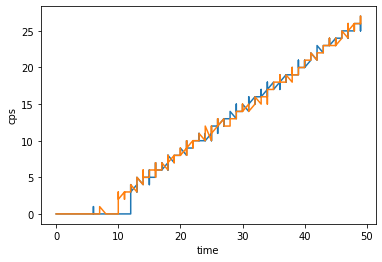

In [9]:
%%host

import matplotlib.pyplot as plt
from numpy import diff

t    =  i_state[:, _STATE_K]
duty =  i_state[:, _STATE_DUTY1]
enc1 =  i_state[:, _STATE_ENC1]
enc2 = -i_state[:, _STATE_ENC2]

cps1 = diff(enc1)/diff(t)
cps2 = diff(enc2)/diff(t)

plt.plot(duty[1:], cps1)
plt.plot(duty[1:], cps2)
plt.xlabel("time")
plt.ylabel("cps")

Text(0, 0.5, 'cps')

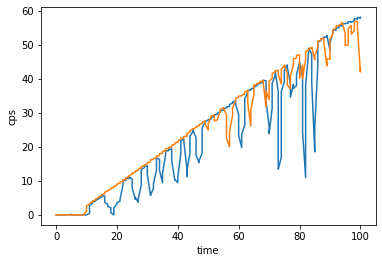

In [34]:
%%host

import matplotlib.pyplot as plt
from numpy import diff

t    = i_state[:, _STATE_K]
duty =  i_state[:, _STATE_DUTY1]
enc1 =  i_state[:, _STATE_ENC1]
enc2 = -i_state[:, _STATE_ENC2]

cps1 = diff(enc1)/diff(t)
cps2 = diff(enc2)/diff(t)

plt.plot(duty[1:], cps1)
plt.plot(duty[1:], cps2)
plt.xlabel("time")
plt.ylabel("cps")